(c) 2022 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [37]:
# Activate project
@load_pkg jlStatGen

# Import project package
import jlStatGen

# Import basic math
import LinearAlgebra
import Distributions

# Load libraries for plotting
using CairoMakie # for static plotting
using WGLMakie # for interactive plotting
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
jlStatGen.viz.pboc_makie!()

# Define output directory
output_dir = "$(git_root())/book/figures/forces_evolution"

"/Users/mrazo/git/stat_gen/book/figures/forces_evolution"

# Wright-Fisher model

In this notebook, we will implement the Wright-Fisher model. As derived in the
main text, the transition probability of this model is of the form
$$
P(X_t=j \mid X_{t-1}=i) = 
\overbrace{\frac{2N!}{i! \left(2N - i\right)!}}
^{\text{order doesn't matter}}
\underbrace{\left( \frac{i}{2N}\right)^j}_
{\text{draw $j$ copies of $A$}}
\overbrace{\left( 1 - \frac{i}{2N} \right)^{2N - j}}^
{\text{draw $j - 2N$ copies of $a$}},
\tag{1}
$$
where $X_t$ is the allele $A$ count at generation $t$, and $N$ is the number of
diploid organisms in the population.

To simulate evolutionary dynamics governed by Eq. (1) such as the dynamics from
the classic 1956 Buri experiment, let us define the vector
$$
\underline{x}_t = (x_t^{(0)}, x_t^{(1)}, \ldots, x_t^{(2N)})^T,
\tag{2}
$$
where each entry $x_t^{(i)}$ is the number of replicate populations with allele
count $i$ at generation $t$. In other words, the vector $\underline{x}_t$ is a
record of the state of all populations at a single generation. Thus, this vector
is of length $|\underline{x}_t| = 2N + 1$, since zero must be counted as a
possible allele copy number. To compute the vector $\underline{x}_{t}$ knowing
vector $\underline{x}_{t-1}$, we define a a $(2N + 1) \times (2N + 1)$
transition matrix $\underline{\underline{P}}$ and compute
$$
\underline{x}_{t} = \underline{\underline{P}}\; \underline{x}_{t-1}.
\tag{3}
$$
Matrix $\underline{\underline{P}}$ has entries
$$
P_{ji} = P(X_t=j \mid X_{t-1}=i),
\tag{4}
$$
given by Eq. (1). Let us define a function that given a population size `N`
returns this matrix.

In [49]:
@doc raw"""
    `Pij(N)`

Function to build Wright-Fisher transition matrix.

# Arguments
- `N::Int`: Number of diploid  organisms in population.

# Returns
- `Pij::Matrix{Float64}`: Wright-Fisher transition matrix.
"""
function Pij(N::Int)
    # Initialize empty matrix
    P_mat = Matrix{Float64}(undef, 2N + 1, 2N + 1)

    # Loop through rows
    for j = 0:2N
        # Loop through columns
        for i = 0:2N
            # Compute and store transition probability
            P_mat[j+1, i+1] = binomial(2N, j) * 
                              (i / 2N)^j * (1 - (i / 2N))^(2N - j)
        end # for cols
    end # for rows

    # Return matrix
    return P_mat
end # function

Pij

With this function in hand, we are ready to simulate the Buri experiment. This
experiment had 107 vials, each with 16 flies. Rather than working with the
number of populations, we will work with the probability of any population
having an allele count $x_t^{(i)}$. Another way to say this is that our vector
$\underline{x}_t$ will keep track of the probability distribution of allele
counts for a population at generation $t$, therefore, $\underline{x}_t$ must
satisfy
$$
\sum_{k=0}^{2N} x_t^{(k)} = 1,
\tag{5}
$$
i.e., it must be a normalized probability.

We will define a matrix `X_mat` where each row will store the probability
distribution of allele counts for each generation. The first row of this matrix
will contain the initial condition for our experiment in which **all**
populations have exactly 16 $A$ alleles.

In [56]:
# Define number of generations that the simulation will run
n_gen = 19

# Define the number of diploid organisms per population
N = 16

# Initialize array to save allele count probability distributions per generation
X_mat = Matrix{Float64}(undef, n_gen + 1, 2N + 1)

# Set initial condition where all entries except for count 16 are zero.
X_mat[1, :] .= 0.0
X_mat[1, 16+1] = 1.0

# Generate transition matrix 
P_mat = Pij(N)

# Loop through generations. Note: The loop starts at 2 and ends at n_gen+1 not
# to modify the initial condition stored in the first row of the matrix
for gen = 2:n_gen+1
    X_mat[gen, :] = P_mat * X_mat[gen-1, :]
end # for

# Check that all generations add up to 1
println("All generations add up to 1: $(all(sum(X_mat, dims=2) .≈ 1.))")

All generations add up to 1: true


We can now plot the time evolution of the allele copy number as a heatmap.

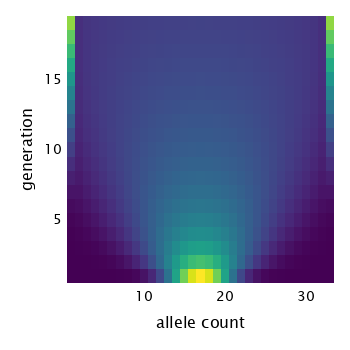

In [65]:
# Define figure resolution
figres = 350

# Inititalize figure
fig = Figure(resolution=(figres, figres))

# Initialize axis
ax = Axis(
    fig[1, 1],
    xlabel = "allele count",
    ylabel = "generation",
)

# Plot heatmap
heatmap!(ax, X_mat[2:end, :]', colormap=:viridis)

fig